In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define our data
years_exp = [1, 3, 4, 6, 8, 10]
salary = [40000, 50000, 55000, 60000, 75000, 85000]

# Create scatter plot
plt.scatter(years_exp, salary, color='red')

# Overplot a sine wave
xwave = np.linspace(0, 10, 100)  # 100 evenly spaced values from 0 to 10
ywave = np.sin(xwave) * 10000 + 60000  # Computes the corresponding sine values and adjust the amplitude and offset

plt.plot(xwave, ywave)

# Add title and labels
plt.title('Salary vs. Years of Experience with Sine Wave')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')

# Show the plot
plt.show()

In [ ]:
import wave
import numpy as np
import matplotlib.pyplot as plt

def load_wave_as_int16(filename):
    with wave.open(filename, 'rb') as w:
        params = w.getparams()
        nchannels, sampwidth, framerate, nframes = params[:4]
        print(params)
        str_data = w.readframes(nframes)
        wave_data = np.frombuffer(str_data, dtype=np.short)
        wave_data.shape = -1, nchannels
        wave_data = wave_data.T
        return wave_data, framerate

# Change the filename to your file's path
# acc = load_wave_as_int16('output/output_voice/accompaniment.wav')
# voc = load_wave_as_int16('output/output_voice/vocals.wav')


data0, rate0 = load_wave_as_int16('output/output_voice/accompaniment.wav')

data1, rate1 = load_wave_as_int16('output/output_voice/vocals.wav')

# Plot the data
time = np.linspace(0., len(data0[0]) / rate0, len(data0[0]))
# plt.figure(figsize=(10, 4))
plt.plot(time, (data0[0]), label='Channel 1')
# plt.plot(time, (data0[0] - data1[0]), label='Channel 1')
# plt.show()

In [ ]:
import soundfile as sf
import resampy
import numpy as np
import matplotlib.pyplot as plt

target_sample_rate = 16000  # Set the sample rate to which you want to downsample.

# Read the audio files and resample them.
signal1, sample_rate1 = sf.read("output4.wav")
signal1_resampled = resampy.resample(signal1, sample_rate1, target_sample_rate)

signal2, sample_rate2 = sf.read("output4/output4/vocals.wav")

signal2_resampled = resampy.resample(signal2[:,0], sample_rate2, target_sample_rate)

# Compute the difference
difference = signal1_resampled - signal2_resampled

# Generate time axis values
time1 = np.linspace(0., len(signal1_resampled)/target_sample_rate, len(signal1_resampled))
time2 = np.linspace(0., len(signal2_resampled)/target_sample_rate, len(signal2_resampled))
time_diff = np.linspace(0., len(difference)/target_sample_rate, len(difference))

plt.figure()

# Plot signal 1
plt.subplot(3, 1, 1)
plt.plot(time1, signal1_resampled)
plt.title("file1.wav")

# Plot signal 2
plt.subplot(3, 1, 2)
plt.plot(time2, signal2_resampled)
plt.title("file2.wav")

# Plot the difference
plt.subplot(3, 1, 3)
plt.plot(time_diff, difference)
plt.title("difference")

plt.tight_layout()
plt.show()

In [ ]:
from pydub import AudioSegment
import os

def convert_ogg_to_wav(ogg_file_path, wav_file_path):
    audio = AudioSegment.from_ogg(ogg_file_path)
    audio.export(wav_file_path, format='wav')
    print(f'Successfully converted {ogg_file_path} to {wav_file_path}')

# put the path to your ogg file here
ogg_file_path = 'output_voice.ogg'  
# put the desired path to your wav file here
wav_file_path = 'output_voice.wav'

convert_ogg_to_wav(ogg_file_path, wav_file_path)


In [ ]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# Assuming you have two signals signal1 and signal2
signal1 = np.random.normal(size = 5000)
signal2 = np.random.normal(size = 5000)

# Apply the cross correlation
corr = scipy.signal.correlate(signal1, signal2, mode='full')

# Get the lag/position of the maximum correlation
lag_max_corr = np.argmax(corr) - (len(signal1) - 1)

# Plot the cross correlation
plt.figure(figsize=(14, 5))
plt.title('Cross-correlation')
plt.plot(corr/)
plt.show()

print(f"The maximum correlation is at lag {lag_max_corr}")

In [ ]:
from scipy.fft import fft
import numpy as np
import scipy.signal as sg
import soundfile as sf
import matplotlib.pyplot as plt

def load_audio(filepath, sr=None, mono=True, dtype='float32'):
    
    x, fs = sf.read(filepath)

    if mono and len(x.shape)>1:
        x = np.mean(x, axis = 1)
    if sr:
        x = sg.resample_poly(x, sr, fs)
        fs = sr 
    x = x.astype(dtype)

    return x, fs

# Original wav track after spleeter
x, fr = load_audio('output4.wav')
x1, fr1 = load_audio('output4/output4/vocals.wav')
x2, fr2 = load_audio('output4/output4/accompaniment.wav')


plt.figure()

plt.subplot(3, 1, 1)
plt.plot(np.linspace(0., len(x) / fr, len(x)), x)
plt.title("1")

# Plot signal 2
plt.subplot(3, 1, 2)
plt.plot(np.linspace(0., len(x1) / fr1, len(x1)), x1)
plt.title("2")


diff = x - x1

# Plot the difference
plt.subplot(3, 1, 3)
plt.plot(np.linspace(0., len(x1) / fr1, len(x1)), diff)
plt.title("difference")




print('np.correlate:', scipy.signal.correlate(x, x1))
print('fft diff:', max(np.abs(fft(x)) - np.abs(fft(x1))))
print('mse', np.mean((x - x1)**2))

# assuming signal1 and signal2 are your two signals
norm_cross_corr = scipy.signal.correlate(x, x1, mode='valid')
norm = np.sqrt(np.sum(x ** 2) * np.sum(x1 ** 2))
if norm != 0:
    norm_cross_corr /= norm
    
# max of cross-correlation will give a measure of similarity
similarity = np.max(np.abs(norm_cross_corr))
print('similarity:', similarity)

# time_diff = np.linspace(0., len(difference)/target_sample_rate, len(difference))

#plt.tight_layout()
plt.show()

In [ ]:
from spleeter.separator import Separator
import numpy as np
import scipy.signal as sg
import soundfile as sf

# Using embedded configuration.
separator = Separator('spleeter:2stems')

# # Using custom configuration file.

def load_audio(filepath, sr=None, mono=True, dtype='float8'):
    
    x, fs = sf.read(filepath)

    if mono and len(x.shape)>1:
        x = np.mean(x, axis = 1)
    if sr:
        x = sg.resample_poly(x, sr, fs)
        fs = sr 
    x = x.astype(dtype)

    return x, fs

# # Original wav track after spleeter
x, fr = load_audio('output4.wav')
x = np.array(x,ndmin = 2)
x = np.transpose(x)
np.shape(x)

import time


t = time.time()
res = separator.separate(x)
print(time.time() - t)
np.shape(res['vocals'][:,0])
x = np.transpose(x)[0]
x1 = res['vocals'][:,0]
print(np.shape(x), np.shape(x1))
norm_cross_corr = scipy.signal.correlate(x, x1, mode='valid')
norm = np.sqrt(np.sum(x ** 2) * np.sum(x1 ** 2))
if norm != 0:
    norm_cross_corr /= norm
similarity = np.max(np.abs(norm_cross_corr))
print('similarity:', similarity)



In [ ]:
class Foo:
    def __init__(self):
        pass

    def someother(self, p=None):
        x = '123'
        if p:
            x = p()
        else:
            x = self.somefun()
        print(x)
        pass

    def somefun(self):
        return 'qwe'
    
    def somefun1(self):
        return 'rty'


def somefun2():
    return 'uio'

f = Foo()
f.someother(somefun2)

for k, v in {1: 2}.items():
    print(k, v)

In [ ]:
class Foo:

    def __init__(self, config: dict):

        self.config = config
    
    def greet(self):
        print(f'greetings, {self.config["model"]}')

c = {"model": "1"}
f = Foo(c)
f.greet()
c['model'] = "2"
f.greet()

In [ ]:
def fill_dict(A, T):
    for key, value in T.items():
        if key not in A:
            if isinstance(value, dict):
                A[key] = fill_dict({}, value)
            elif isinstance(value, list):
                A[key] = value[:]
            else:
                A[key] = value
        elif isinstance(A[key], dict) and isinstance(value, dict):
            A[key] = fill_dict(A[key], value)
        elif isinstance(A[key], list) and isinstance(value, list):
            A[key] += [item for item in value if item not in A[key]]
    return A

schema = {
    'rty': '',
    'qweqwe': '',
    's' : {'a':''},
    '1':[{'a':1}, 1]
}

config = {
    's': {'a': 1},
    'qweqwe': 'qweqwe',
    'rty': 1,
    '1': [{'a':2}, 1]
}

fill_dict(config, schema)
'1 2 3'.split(maxsplit=1)

def enumerate_keys(input_dict, parent_key = ''):
    for k, v in input_dict.items():
        current_key = f"{parent_key}.{k}" if parent_key else k
        if isinstance(v, dict):
            yield from enumerate_keys(v, current_key)
        else:
            yield current_key

dict_input = {'a': {'b':1}}

list(enumerate_keys(dict_input))

def set_value(d, key, value):
    keys = key.split('.')
    current_dict = d
    for k in keys[:-1]:
        current_dict[k] = current_dict.get(k, {})
        current_dict = current_dict[k]
    current_dict[keys[-1]] = value
    return d

def get_value(d, key):
    keys = key.split('.')
    current_dict = d
    for k in keys[:-1]:
        current_dict[k] = current_dict.get(k, {})
        current_dict = current_dict[k]
    return current_dict[keys[-1]]


d = {}

set_value(d, '1.2.3.4', '4')
set_value(d, '1.2.3.4', '5')
set_value(d, '1.2', '5')

get_value(d, '1.2')
import json

json.loads(json.dumps({'1': None}))

In [ ]:
class DataObject:
    def __init__(self, data_dict):
        self.__dict__ = data_dict

# Sample dictionary
my_dict = {'name': 'Alice', 'age': 30, 'city': 'New York'}

# Create a data object from the dictionary
data_obj = DataObject(my_dict)

# Access the data object attributes
print(data_obj.name)  # Output: Alice
print(data_obj.age)   # Output: 30
print(data_obj.city)  # Output: New York

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create a black image
image = np.full((1000, 4000, 3), (255, 255, 255), dtype=np.uint8)

GRID_WIDTH = 250


'''
00x00
0x0x0
00x00
0x0x0
00x00
'''


def draw(image, i, j):
    cv2.line(image, (, 0), (511, 511), (0, 0, 0), 5)

draw(image)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('on')  # Do not show axis to resemble cv2.imshow
plt.show()

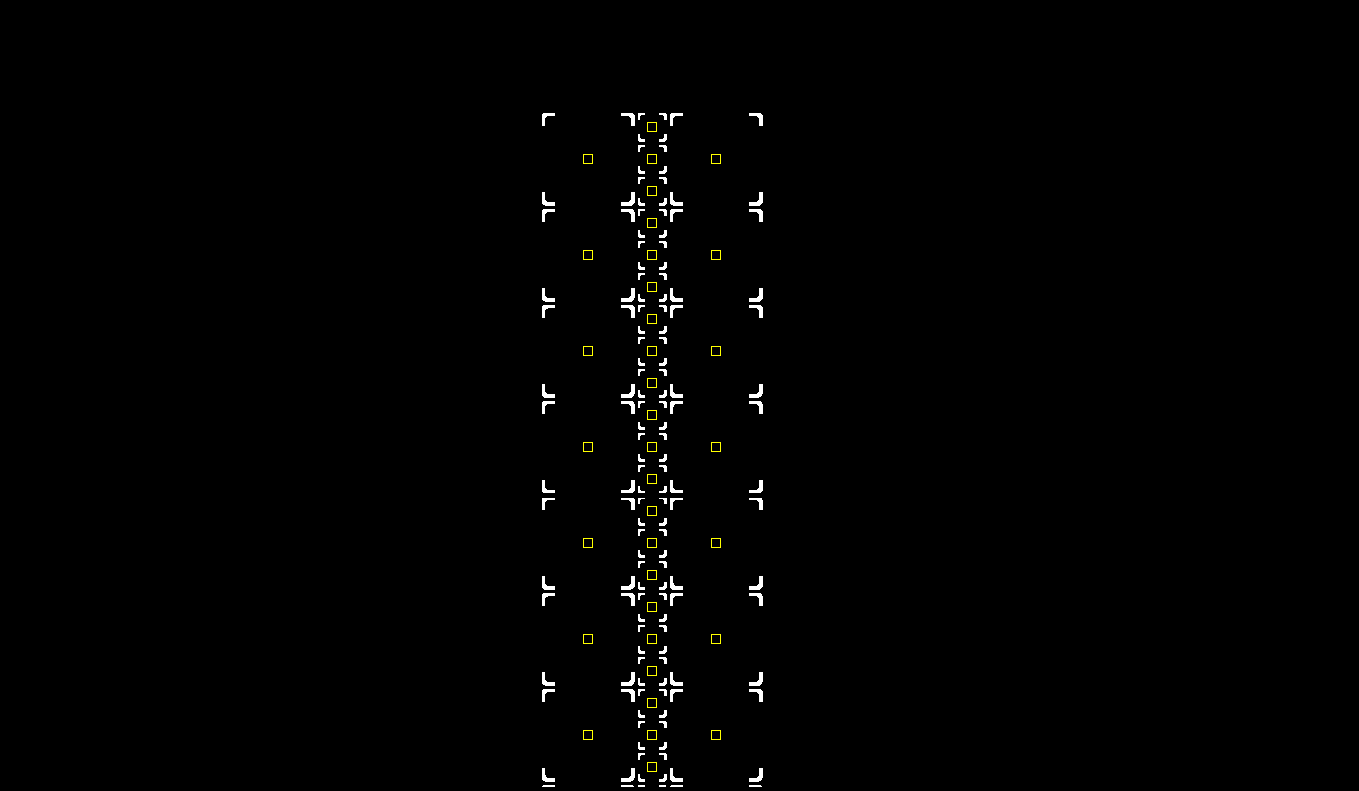

In [2]:
import cv2
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
# from skimage.morphology import skeletonize


import sys
from pathlib import Path

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))
# import common
from common import *
from mapar.snail import Snail

import cv2 as cv
import numpy as np

im1 = cv.imread('../tmp/test_get_tooltip1_im1.bmp')
im2 = cv.imread('../tmp/test_get_tooltip1_im2.bmp')

mask = get_marks(im1, im2)

# i = 1
# cross_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
# mask = cv.erode(mask, cross_kernel, iterations=i)
# mask = cv.dilate(mask, cross_kernel, iterations=i)


out = mask.copy()
out = cv.cvtColor(out, cv.COLOR_GRAY2BGR)

# dis(mask)

ents = get_entity_coords_from_marks(mask, im1)

for e in ents:
    cv.rectangle(out, (*(e - (5,5)), 10, 10), (255,255,0), 1)
dis(out)


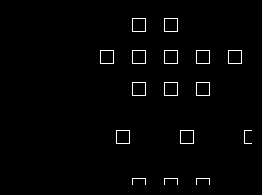

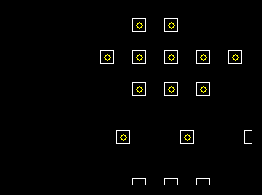

In [6]:
import cv2 as cv
import numpy as np

import sys
from pathlib import Path

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))
# import common
from common import *
# print(common)

im = cv.imread('../tmp/ent1.png')




im = margin(im)
im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
# im = cv.inRange(im, (0, 255, 0), (0, 255, 0))
out = im.copy()
out = cv.cvtColor(out, cv.COLOR_GRAY2BGR)
# dis(im)


def margin(original_image, margin_width = 10):
    original_height, original_width = original_image.shape[:2]
    new_width = original_width + 2 * margin_width
    new_height = original_height + 2 * margin_width
    new_image = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    new_image[margin_width:margin_width + original_height, margin_width:margin_width + original_width] = original_image
    return new_image

def flood_fill_contour(img, seed_point, mark_width = 15):
    sp = np.array(seed_point)
    ofs = np.array((mark_width, mark_width))
    loc = crop_image(img, Rect(*(sp - ofs), *(ofs*2)))
    img = loc
    h, w = img.shape[:2]
    flood_fill_mask = np.zeros((h + 2, w + 2), np.uint8)
    num, im, mask, rect = cv.floodFill(img, flood_fill_mask, ofs, 255)
    mask = (mask * 255).astype(np.uint8)
    mask[0,:] = 0
    mask[-1,:] = 0
    mask[:,0] = 0
    mask[:,-1] = 0
    y, x = np.where(mask > 0)
    sx, sy = sp
    sp_inv = np.array((sx,sy))
    contour_pixels = np.array(list(zip(x, y)))
    return np.array([p + sp_inv-ofs - (1,1) for p in contour_pixels])



def entity_pos(im):
    py, px = np.where(im > 0)
    pts = set(zip(px, py))
    i = 0
    ents = []
    while pts:
        sp = pts.pop()
        cp = flood_fill_contour(im, sp)
        r = Rect(*cv.boundingRect(cp))
        if r.w * r.h < 13 * 13:
            continue
        # cv.rectangle(out, r.xywh(), (255,255,0), 1)
        for x, y in cp:
            if (x, y) in pts:
                pts.remove((x, y))
        i += 1
        
        ents.append(r.center())
    return ents

cs = entity_pos(im)

for c in cs:
    cv.circle(out, c, 3, (255, 255,0), 1)

dis(im, out)

In [160]:
s = set([1])
s.pop()

1

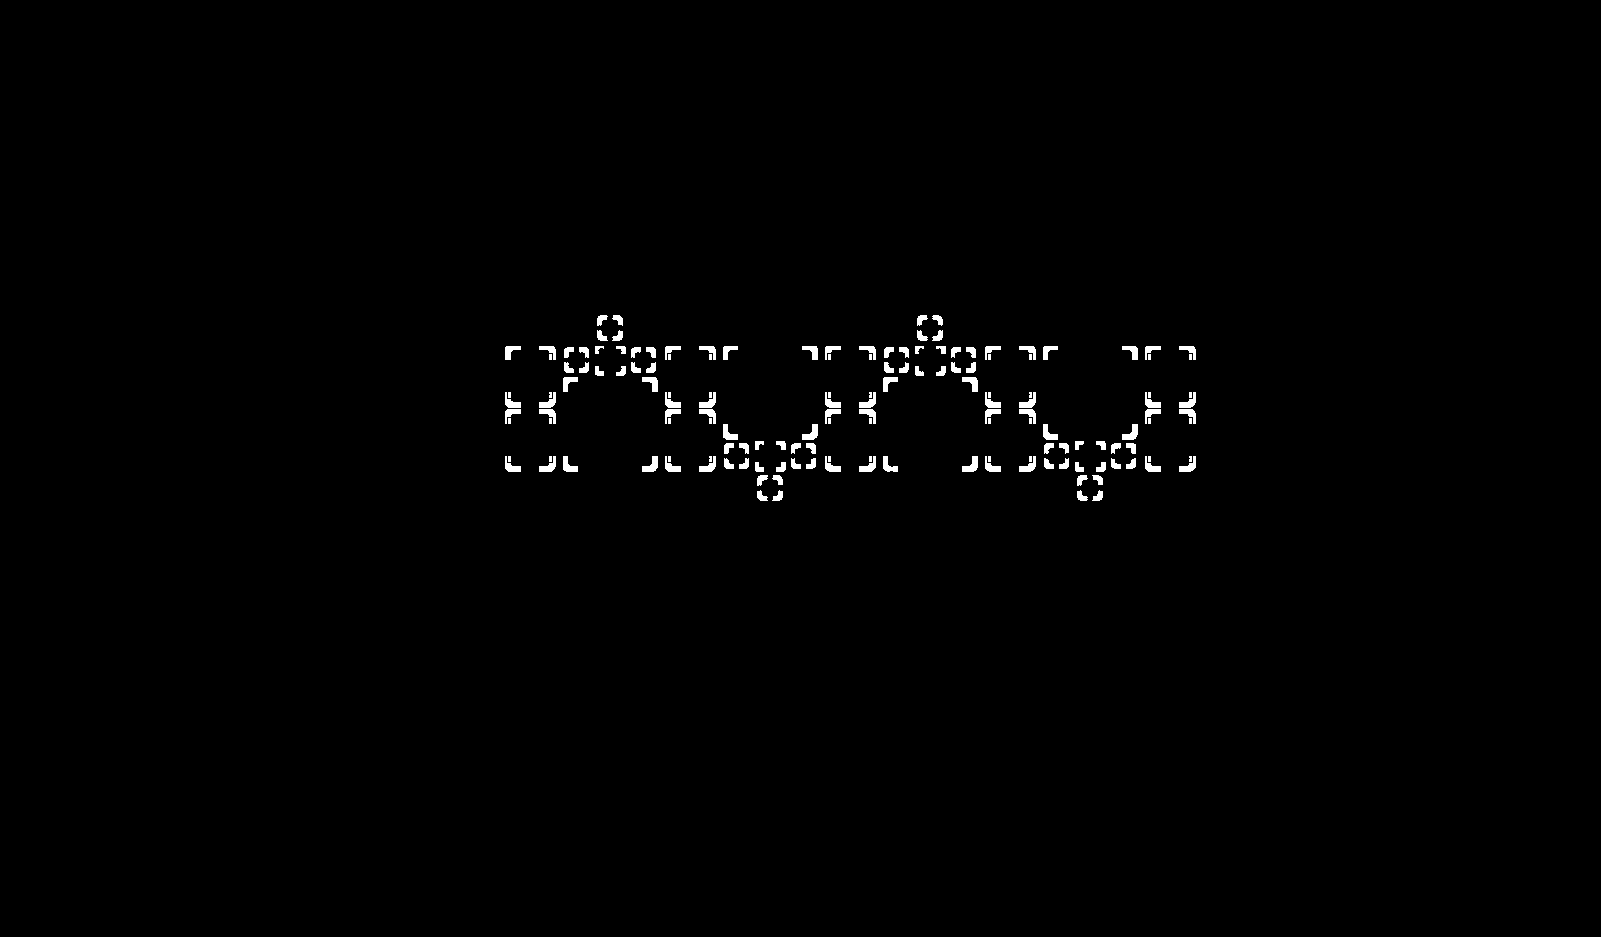

In [46]:
# Load the image
img = im1
lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
lower_red = np.array([20, 150, 150])  # Example values for lower bound
upper_red = np.array([255, 255, 255])  # Example values for upper bound
mask = cv2.inRange(lab_img, lower_red, upper_red)
mask = cv2.bitwise_and(mask, r)

dis(mask)

In [67]:
l = [1,1,1,1,1,1,1,1,1,1,1,1,7]
len(l)



i = 2
while l[i] < 10:

13

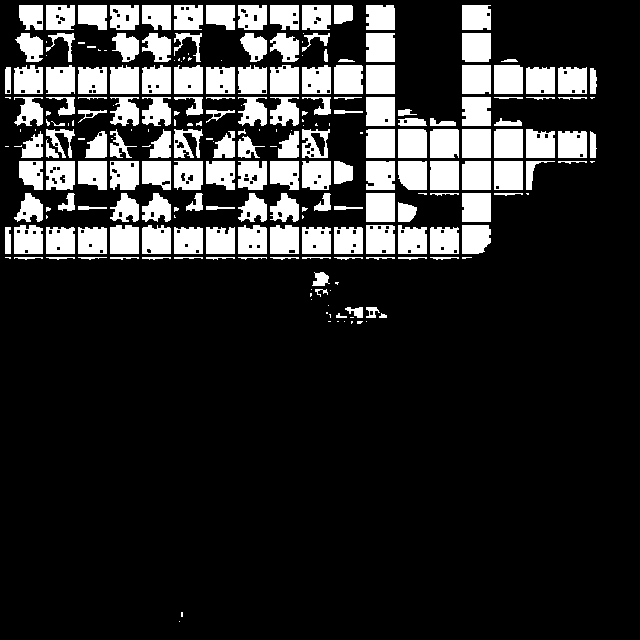

In [2]:
import cv2 as cv
import numpy as np
import sys
from pathlib import Path

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))
# import common
from common import *
from mapar.snail import Snail


im1 = cv.imread('../tmp/test_get_tooltip1_im1.bmp')
im2 = cv.imread('../tmp/test_get_tooltip1_im2.bmp')

r = cv.bitwise_xor(im1, im2)

r = cv.cvtColor(r, cv.COLOR_BGR2GRAY)

_, binary_mask = cv.threshold(r, 0, 255, cv.THRESH_BINARY)

binary_mask = (binary_mask * 1).astype(np.uint8)

marks = get_marks(im1, im2)

dis(marks)



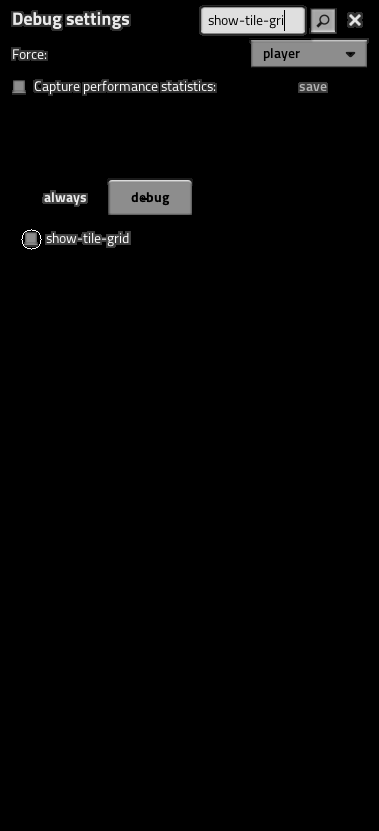

In [13]:
import cv2 as cv
import numpy as np

im = cv.imread('../tmp/test_open_debug_options_im.bmp')

im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
_, mask = cv.threshold(im, 128, 255, cv.THRESH_BINARY)
mask = dilate(mask, 2, cv.MORPH_RECT)
im = cv.bitwise_and(im, im, mask=mask)
ccs = get_ccs(mask, with_br=True)
h, w = mask.shape
p = np.array((0, h))
srt = sorted(ccs, key=lambda x: np.linalg.norm(p - Rect(*x[1]).xy()))
c = Rect(*srt[0][1]).center()
cv.circle(im, c, 10, 255, 1)
dis(im)

In [2]:
from sklearn.cluster import KMeans
def get_dominant_colors(image, k=5):
    # Convert the image to RGB (OpenCV loads images in BGR by default)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Reshape the image into a 2D array of pixels
    pixels = image.reshape((-1, 3))

    # Apply KMeans to find the top k colors
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pixels)
    
    # The cluster centers are our dominant colors.
    colors = kmeans.cluster_centers_

    return colors, kmeans.labels_

def recreate_image(centroids, labels, w, h):
    '''Recreate the (compressed) image from the cluster centers & labels'''
    d = centroids.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = centroids[labels[label_idx]]
            label_idx += 1
    return image


def get_reduced_img(img1, k = 6):
    dominant_colors, labels = get_dominant_colors(img1, k)

    # Recreate the image using the dominant colors
    w, h, _ = img1.shape
    new_image = recreate_image(dominant_colors, labels, w, h)

    # Convert the image back to BGR
    # new_image_bgr = cv2.cvtColor(new_image.astype(np.uint8), cv2.COLOR_RGB2BGR)
    return new_image.astype(np.uint8)


def posterize(image, level):
    """
    Posterize an image to reduce the number of colors.

    :param image: Input image (numpy array).
    :param level: Level of posterization (number of different shades per channel).
    :return: Posterized image.
    """
    level = max(2, level)  # Ensure level is at least 2 to avoid zero-division
    # Calculate the quantization step
    step = 256 // level

    # Apply the quantization to each channel
    posterized_img = (image // step) * step + step // 2

    return posterized_img

def posterize_blk(image, level):
    """
    Posterize an image while preserving black colors.

    :param image: Input image (numpy array).
    :param level: Level of posterization (number of different shades per channel).
    :return: Posterized image with preserved black colors.
    """
    # Create a mask for the black regions
    black_mask = np.all(image == [0, 0, 0], axis=-1)

    # Calculate the quantization step
    step = 256 // max(2, level)  # Ensure level is at least 2 to avoid zero-division

    # Apply the quantization to each channel
    posterized_img = (image // step) * step + step // 2

    # Reapply the black color to the regions indicated by the mask
    posterized_img[black_mask] = [0, 0, 0]

    return posterized_img

def count_gray_pixels(image, threshold=1):
    
    # If the image is not read correctly
    if image is None:
        raise ValueError("Image not found or unable to read the image.")
    
    # Split the image into its color channels
    b, g, r = cv2.split(image)
    
    # Calculate the absolute differences between the channels
    max_diff = np.max(np.array([b, g, r]), axis=0) - np.min(np.array([b, g, r]), axis=0)
    
    # Create a mask where the difference is below the threshold
    gray_mask = max_diff <= threshold
    
    # Count the number of gray pixels
    number_of_gray_pixels = np.sum(gray_mask)
    
    return number_of_gray_pixels

def count_gray_pixels1(image, threshold=10):
    # If the image is not read correctly
    if image is None:
        raise ValueError("Image not found or unable to read the image.")
    
    # Split the image into its color channels
    b, g, r = cv2.split(image)
    
    # Calculate the absolute differences between the channels
    max_diff = np.max(np.array([b, g, r]), axis=0) - np.min(np.array([b, g, r]), axis=0)
    
    # Create a mask where the difference is below the threshold
    gray_mask = max_diff <= threshold
    
    # Count the number of gray pixels
    number_of_gray_pixels = np.sum(gray_mask)
    
    # Convert boolean mask to 8-bit format (0 or 255)
    gray_mask_uint8 = (gray_mask * 255).astype(np.uint8)
    
    return number_of_gray_pixels, gray_mask_uint8

def get_prevalent_color(image):
    reshaped_array = image.reshape(-1, image.shape[-1])

    # Get unique colors and their counts
    unique_colors, counts = np.unique(reshaped_array, axis=0, return_counts=True)

    # Create the dictionary with counts
    color_counts_dict = {tuple(color): count for color, count in zip(unique_colors, counts)}
    cc = max(color_counts_dict.items(), key=lambda x: x[1])
    # print(cc)
    return cc


In [8]:
'''
this snippet shows how to select belts
'''

import cv2 as cv
import numpy as np
import cv2

import sys
from pathlib import Path

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))
# import common
from common import *
from sklearn.cluster import KMeans

alpha = 0.001
bg = cv.imread('../tmp/test_get_tooltip1_bg.bmp')
bg = cv.cvtColor(bg, cv.COLOR_BGR2RGB)
comp = cv.imread('../tmp/test_get_tooltip1_comp.bmp')
comp = cv.cvtColor(comp, cv.COLOR_BGR2RGB)
def get_foreground(bg, comp):
    im = comp.copy()
    # im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    comp = comp.astype(np.float32)
    bg = bg.astype(np.float32)
    fg = (comp - bg)
    fg = np.clip(fg, 0, 255).astype(np.uint8)
    # fg = cv.cvtColor(fg, cv.COLOR_BGR2RGB)
    fg = posterize_blk(fg, 5)
    return fg

fg = get_foreground(bg, comp)
# dis(fg)
vl, hl, mvl, mhl, gw = get_grid(comp, grid_color=(32,32,32))
xy = grid(vl, hl)
# print(xy)
# import itertools
dd = {}
coords = {}


marks = cv.imread('../tmp/test_get_tooltip1_marks.bmp')
marks = cv.cvtColor(marks, cv.COLOR_BGR2GRAY)
ents, ents1 = get_entity_coords_from_marks(marks, comp.astype(np.uint8), grid_color=(32,32,32))

map_c_to_e = {}
for e in ents1:
    map_c_to_e[e.top_left] = e.size
    # print(e.top_left)
#

gw, gh, _ = xy.shape

# for i in range(gw):
    # for j in range(gh):

bmap = np.array([['_'] * gh] * gw)

# print(bmap)
for i, (x, y) in enumerate(itertools.product(vl, hl)):
    # x, y = xy[(i, j)]
    w = 32
    ww = 20

    ii = i // len(vl)    
    jj = i % len(vl)

    c = get_cell_at(fg, (x,y), 32)
    cc = crop_image(c, Rect(w//2-ww//2, w//2-ww//2, ww,ww))
    cnt = np.count_nonzero(cc != (0,0,0))
    if cnt > 32 * 1:
        msk = ((cc != (0,0,0)) * 100).astype(np.uint8)
        # print(i)
        # dis(c, msk)
        rr = Rect(w//2-ww//2,w//2-ww//2, ww, ww)
        cw = crop_image(c, rr)
        dd[i] = [c, cv2.GaussianBlur(cw, (3,3), 0, 0).astype(np.float32)]
        coords[i] = (x, y)
        # putOutlinedText(im, f'{ii}, {jj}', (x+2, y + 16), sz=0.35)
        putOutlinedText(fg, f'{i}', (x+2, y + 16), sz=0.35)
        cf = cw.astype(np.float32)
        cgf = cv.cvtColor(cv.cvtColor(cw, cv.COLOR_RGB2GRAY), cv.COLOR_GRAY2RGB).astype(np.float32)
        res = np.clip(cf - cgf, 0, 256).astype(np.uint8)
        _, res = cv.threshold(res, 20, 255, cv.THRESH_BINARY)
        cnt = np.count_nonzero(res)
        # putOutlinedText(im, str(cnt), (x+2, y + 16), sz=0.35)
        h, w, _ = cw.shape
        gr = cv.cvtColor(cw, cv.COLOR_RGB2GRAY)
        # dis(gr)
        cntblk = h * w - cv.countNonZero(gr)
        # cntblk = np.count_nonzero(c)
        cntgry, gmsk = count_gray_pixels1(cw, threshold=20)

        # if (cntgry - cntblk) / (h*w) > 0.68:
        col, cnum = get_prevalent_color(cw)

        ddd = {
            'top-left-ccw': 'tlc',
            'top-left-cw': 'tl',
            'top-right-ccw': 'trc',
            'top-right-cw': 'tr',
            'bottom-left-ccw': 'blc',
            'bottom-left-cw': 'bl',
            'bottom-right-ccw': 'brc',
            'bottom-right-cw': 'br',
            'up': 'u',
            'down': 'd',
            'left': 'l',
            'right': 'r',
            None: 'nnn'
        }

        if col == (25,25,25):
            # putOutlinedText(fg, str(cnum), (x+2, y + 16), sz=0.35)
            if cnum >= 275:
                if (ii, jj) in map_c_to_e:
                    sz = map_c_to_e[(ii, jj)]
                    if sz.tolist() == [1,1]:
                        # cv.circle(fg, (x+16, y+16), 11, (128,128,128), 1)
                        d = classify_image(c)
                        # print(d)
                        if d in map_corner_to_dir:
                            d = corner_to_dir(d)
                        bmap[jj][ii] = d[0]
                        # print(f'{jj},{ii},{d[0]}')
                        putOutlinedText(fg, f'{d[0]}', (x+10, y + 16), sz=0.35)
                        pass
                pass

        # cols = frozenset(tuple(pixel) for row in cw for pixel in row)

        # if len(cols.difference(belt_colors)) < 4:
            # cv.circle(im, (x+16, y+16), 3, (255,0,0), 1)
    # cell_loc()
    # cv.circle(im, (x, y), 3, (255,255,255), 1)


def is_similar(cell_dict, indx1, indx2):

    # assert img1.shape == img2.shape
    # h, w, _ = img1.shape
    # assert w == h
    # img1 = cv2.GaussianBlur(img1, (3,3), 0, 0)
    # img2 = cv2.GaussianBlur(img2, (3,3), 0, 0)
    # img1 = img1.astype(np.float32)
    # img2 = img2.astype(np.float32)
    img1, img2 = cell_dict[indx1][1], cell_dict[indx2][1]

    img11, img22 = cell_dict[indx1][0], cell_dict[indx2][0]

    c1 = frozenset(tuple(pixel) for row in img11 for pixel in row)
    c2 = frozenset(tuple(pixel) for row in img22 for pixel in row)
    # print(sorted(list(c1)))
    # print(sorted(list(c2)))
    max(len(c1), len(c2))
    c3 = c1.union(c2)
    print(len(c3), len(c2), len(c1))

    msk1 = np.clip(img2 - img1, 0, 255).astype(np.uint8)
    _, msk1 = cv.threshold(msk1, 20, 255, cv.THRESH_BINARY)
    cnt1 = np.count_nonzero(msk1)
    msk2 = np.clip(img1 - img2, 0, 255).astype(np.uint8)
    _, msk2 = cv.threshold(msk2, 20, 255, cv.THRESH_BINARY)
    cnt2 = np.count_nonzero(msk2)
#   # print(max(cnt1, cnt2))
    # dis(msk1, msk2, img1.astype(np.uint8), img2.astype(np.uint8))
    h, w, _ = msk2.shape
    diff = max(cnt1, cnt2)
    similar_rate = (h * w - diff) / (h * w)
    # print(similar_rate)


    return similar_rate >= 0.7

lst = [364, 362, 363, 556, 392]
lst = [364, 686, 782]
lst = [685, 686, 717, 718, 781, 782, 813, 814, 422, 364, 432]
# lst = [685, 781]
# lst = [717, 813]
# lst = [686,782]
lst = [718, 814]
lst = [428, 429]
# lst = [166, 171]
# imgs = [dd[idx][0] for idx in lst]


""" for img, idx in zip(imgs, lst):
    print(classify_image(img))
    print(idx)
    dis(img)
    # break
 """

# qwe = [''.join(r) for r in bmap]
# print('\n'.join(qwe))
s = '\n'.join([''.join(row.tolist()) for row in bmap])
    

print(s)
dis(dd[498][1])



___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________


TypeError: Cannot handle this data type: (1, 1, 3), <f4

In [4]:
'''
this snippet shows how to select belts
'''

import cv2 as cv
import numpy as np
import cv2

import sys
from pathlib import Path

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))
# import common
from common import *
from sklearn.cluster import KMeans

alpha = 0.001
bg = cv.imread('../tmp/test_get_tooltip1_bg.bmp')
comp = cv.imread('../tmp/test_get_tooltip1_comp.bmp')

fg = get_foreground(bg, comp)
vl, hl, mvl, mhl, gcw = get_grid(comp)
marks = cv.imread('../tmp/test_get_tooltip1_marks.bmp')
marks = cv.cvtColor(marks, cv.COLOR_BGR2GRAY)
ents, ents1 = get_entity_coords_from_marks(marks, comp.astype(np.uint8))
# print(ents1)

map_c_to_e = get_cell_to_entity_map(ents1)
print(map_c_to_e)
bmap = get_belt_map(vl, hl, gcw, map_c_to_e, fg)


s = '\n'.join([''.join(row.tolist()) for row in bmap])

g = get_strmap_to_grid(s)
paths = strmap_to_paths(s)
print(paths)
print(s)
# dis(fg)



{(8, 16): array([2, 2]), (9, 5): array([1, 1]), (9, 14): array([1, 1]), (10, 5): array([1, 1]), (10, 14): array([1, 1]), (11, 5): array([1, 1]), (11, 14): array([1, 1]), (11, 16): array([1, 1]), (11, 17): array([1, 1]), (11, 18): array([1, 1]), (12, 5): array([1, 1]), (12, 14): array([1, 1]), (12, 16): array([2, 2]), (13, 5): array([1, 1]), (13, 14): array([1, 1]), (14, 5): array([1, 1]), (14, 14): array([1, 1]), (15, 5): array([1, 1]), (15, 6): array([1, 1]), (15, 7): array([1, 1]), (15, 8): array([1, 1]), (15, 9): array([1, 1]), (15, 10): array([1, 1]), (15, 11): array([1, 1]), (15, 12): array([1, 1]), (15, 13): array([1, 1]), (15, 14): array([1, 1]), (15, 16): array([1, 1]), (15, 18): array([2, 1]), (16, 10): array([1, 1]), (17, 10): array([1, 1]), (18, 10): array([1, 1]), (19, 10): array([1, 1]), (20, 10): array([1, 1])}
[[array([5, 9]), array([5, 8])], [array([ 5, 12]), array([ 5, 13])]]
__________________________
__________________________
__________________________
_____________

32
[89, 5, 139, 110]
414


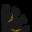

[89, 5, 139, 110]
[89, 5, 139, 110]
________________________
________________________
________________________
_______u________________
_______u__d_dllllll_____
_______u__d_d_____u_____
_______u__d_rrrrrdu_____
_______u__d_dlllllu_____
______rul_d_rrrrrdu_____
______uuu_d______du_____
______uuu_d__lllllu_____
______u_u_d_______u_____
______u_u_rrrrrrrru_____
______u_u_______________
________________________
________________________
________________________
________________________
________________________
________________________
________________________
________________________
________________________
________________________


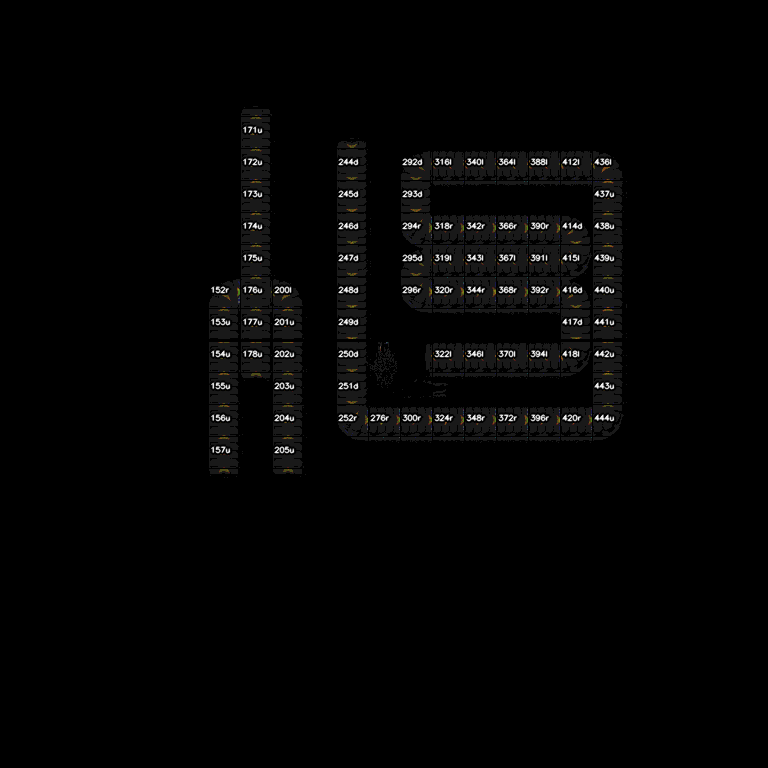

In [63]:
'''
this snippet shows how to select belts
'''

import cv2 as cv
import numpy as np
import cv2

import sys
from pathlib import Path

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))
import common
from common import *
from npext import *
from sklearn.cluster import KMeans

alpha = 0.001
bg = cv.imread('../tmp/test_get_tooltip1_bg.bmp')
comp = cv.imread('../tmp/test_get_tooltip1_comp.bmp')
comp = cv.cvtColor(comp, cv.COLOR_BGR2RGB)
bg = cv.cvtColor(bg, cv.COLOR_BGR2RGB)
# dis(comp)
def get_foreground(bg, comp):
    im = comp.copy()
    # im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    comp = comp.astype(np.float32)
    bg = bg.astype(np.float32)
    fg = (comp - bg)
    fg = np.clip(fg, 0, 255).astype(np.uint8)
    # fg = cv.cvtColor(fg, cv.COLOR_BGR2RGB)
    fg = posterize_blk(fg, 5)
    return fg

fg = get_foreground(bg, comp)
# dis(fg)

vl, hl, mvl, mhl, gcw = get_grid(comp, grid_color=(32,32,32))
import itertools
# dis(comp)
print(gcw)

marks = cv.imread('../tmp/test_get_tooltip1_marks.bmp')
marks = cv.cvtColor(marks, cv.COLOR_BGR2GRAY)
ents, ents1 = get_entity_coords_from_marks(marks, comp.astype(np.uint8), grid_color=(32,32,32))

def get_cell_to_entity_map(entities):
    map_c_to_e = {}
    for e in ents1:
        map_c_to_e[e.top_left] = e.size
    return map_c_to_e

def classify_ints(integers):
    def max_dev(integers):
        sorted(integers)
        m = np.mean(integers)
        d = np.abs(integers - m)
        return np.max(d)
    ints = sorted(integers) 
    md3 = max_dev(ints[1:])
    md = max_dev(ints)
    if md3 < 30 and md > 20:
        return 'corner'
    else:
        return 'straight'

def classify_turn(img, iii, iset):
    img = img.astype(np.uint8)
    h, w, _ = img.shape
    ww = 30
    rect = Rect(0, 0, ww, ww)
    cimg = (npext(img) | crop(Rect(w//2 - ww//2, w//2-ww//2, ww,ww))).array
    www = 12
    dd = {
        Rect(rect.x0, rect.y0, www, www): 'top-left',
        Rect(rect.x0 + rect.w - www, rect.y0, www, www): 'top-right',
        Rect(rect.x0, rect.y0 + rect.h - www, www, www): 'bottom-left',
        Rect(rect.x0 + rect.w - www, rect.y0 + rect.h - www, www, www): 'bottom-right'
    }

    def nz_mask(img):
        msk = np.where(np.any(img != (0, 0, 0), axis=-1), 255, 0).astype(np.uint8)
        return msk

    rects = cimg.copy()
    for k, v in dd.items():
        cv.rectangle(rects, k.xy(), np.array(k.xy()) + k.wh(), (255, 0, 0), 1)


    cnts = [cv.countNonZero(nz_mask(crop_image(cimg, k))) for k, v in dd.items()]

    if iii in iset:
        print(cnts)

    if classify_ints(cnts) == 'straight':
        return None, rects, cnts
    else:
        tpl = min(dd.items(), key=lambda tpl: cv.countNonZero(nz_mask(crop_image(cimg, tpl[0]))))
        return tpl[1], rects, cnts

def classify_image(img, iii = None, iset = {}):
    assert len(img.shape) == 3
    w = 32
    t, _, _ = classify_turn(img, iii, iset)
    p = 20
    q = 20 // 4
    def cmp(img, r1, r2, s1, s2):
        i1 = npext(img) | crop(r1) | to_gray() | bin_threshold(60, 255)
        i2 = npext(img) | crop(r2) | to_gray() | bin_threshold(60, 255)
        return s1 if cv.countNonZero(i1.array) < cv.countNonZero(i2.array) else s2
    img_orig = img.copy()     
    if t is None:
        
        # get a subimage of 12x12 size inside original, because on the
        # edges it can contain noise
        ww = 12
        r = Rect(w//2-ww//2, w//2-ww//2, ww, ww)
        img = crop_image(img, r)
        # img_post = posterize_blk(img, 6)
        
        # get most common color and paint it black
        cc, cnt = get_prevalent_color(img)
        # img = img_post
        msk = np.all(img == cc, axis=-1)
        img[msk] = (0, 0, 0)
        
        # flatten image into binary mask, it should coninatin
        # only arrow by which we deduce belt direction
        img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        _, img = cv.threshold(img, 30, 255, cv.THRESH_BINARY)
        
        contour = find_contour(img)
        if iii in iset:
            dis(img, img_orig)

        # depending on dimensions of arrow bounding box decide
        # the direction of belt
        brect = cv.boundingRect(contour)

        if brect[2] > brect[3]:
            r1 = Rect(w//2 - p//2, 1, p, q-1)
            r2 = Rect(w//2 - p//2, w-q, p, q-1)
            return cmp(img_orig, r1, r2, 'down', 'up')
        else:
            r1 = Rect(1, w//2 - p//2, q-1, p)
            r2 = Rect(w-q, w//2 - p//2, q-1, p)
            return cmp(img_orig, r1, r2, 'right', 'left')
    else:
        if t == 'top-left':
            r1 = Rect(w//2 - p//2, w - q, p, q-1)
            r2 = Rect(w - q, w//2 - p//2, q-1, p)
            return cmp(img_orig, r1, r2, 'top-left-cw', 'top-left-ccw')
        if t == 'top-right':
            r1 = Rect(w//2 - p//2, w - q, p, q-1)
            r2 = Rect(1, w//2 - p//2, q-1, p)
            return cmp(img_orig, r1, r2, 'top-right-ccw', 'top-right-cw')
        if t == 'bottom-right':
            r1 = Rect(1, w//2-p//2, q-1, p)
            r2 = Rect(w//2 - p//2, 1, p, q-1)
            return cmp(img_orig, r1, r2, 'bottom-right-ccw', 'bottom-right-cw')
        if t == 'bottom-left':
            r1 = Rect(w-q, w//2-p//2, q-1, p)
            r2 = Rect(w//2 - p//2, 1, p, q-1)
            return cmp(img_orig, r1, r2, 'bottom-left-cw', 'bottom-left-ccw')

def get_belt_map(vl, hl, gcw, map_c_to_e, fg, iset = {}):
    bmap = np.array([['_'] * len(hl)] * len(vl))
    w, ww = gcw, 20
    rr = Rect(w//2-ww//2,w//2-ww//2, ww, ww)
    for i, (x, y) in enumerate(itertools.product(vl, hl)):
        ii, jj = i // len(hl), i % len(hl)
        
        c = get_cell_at(fg, (x,y), gcw)
        if c.shape != (32, 32, 3):
            continue
        # cv.rectangle(fg, (x,y), (x+32, y+32), (255,0,0), 1)
        cw = crop_image(c, rr)
        if cw.shape != (20, 20, 3):
            continue
        msk = cv.cvtColor(cw, cv.COLOR_RGB2GRAY)
        # cw.emp
        _, msk = cv.threshold(msk, 20, 255, cv.THRESH_BINARY)
        # skip cell if there's no significant pixels
        if cv.countNonZero(msk) < 32 * 1:
            continue
        
        # putOutlinedText(fg, f'{i}', (x, y + 16), sz=0.35)
        col, cnum = get_prevalent_color(cw)
        # skip cell if gray is not prevalent color
        if col != (25,25,25):
            continue
        # skip cell if not enough pixels are gray
        if cnum < 275:
            continue

        # skip cell if it not on cell to entity map
        if (ii, jj) not in map_c_to_e:
            continue
        sz = map_c_to_e[(ii, jj)]
        # skip cell if it corresponds to entity not of 1x1 size
        if sz.tolist() != [1,1]:
            continue

        t, rects, cnts = classify_turn(c, i, iset)
        if i in iset:
            print(i)
            dis(rects, c)
            print(cnts)


        # after all the filtering real cell processing code comes here
        d = classify_image(c, i, iset)
        if d in map_corner_to_dir:
            d = corner_to_dir(d)
        if d is None:
            d = '_'
        bmap[jj][ii] = d[0]
        # t = classify_turn(c)
        # if t is None:
            # d = 'straight'
        # else:
            # d = t
        putOutlinedText(fg, f'{i}{d[0]}', (x+2, y + 16), sz=0.25)
    return bmap

map_c_to_e = get_cell_to_entity_map(ents1)
bmap = get_belt_map(vl, hl, gcw, map_c_to_e, fg, iset={414})


s = '\n'.join([''.join(row.tolist()) for row in bmap])
    
print(s)
dis(fg)



In [6]:
import cv2
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

lbls = dict()

cls = dict()
for i, (idx1, [img1, img1_mod]) in enumerate(dd.items()):
    for j, (idx2, [img2, img2_mod]) in enumerate(dd.items()):
        if i == j:
            continue
        # print(is_similar(dd, idx1, idx2))
        fnd1 = False
        fnd2 = False
        for c, (idx, idxset) in cls.items():
            if is_similar(dd, idx, idx1):
                cls[c][1].add(idx1)
                fnd1 = True

            if is_similar(dd, idx, idx2):
                cls[c][1].add(idx2)
                fnd2 = True
        if not fnd1:
            cc = len(cls)
            cls[cc] = (idx1, {idx1})
        if not fnd2:
            cc = len(cls)
            cls[cc] = (idx2, {idx2})

# dis()
# for cc, (img, imgsn) in cls.items():
    # print(cc)
    # imgs = [images[ii] for ii in imgsn]
    # dis(*imgs)


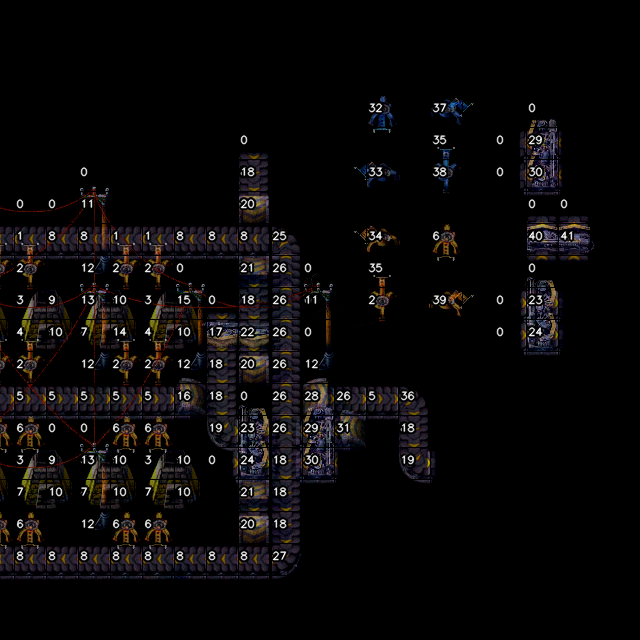

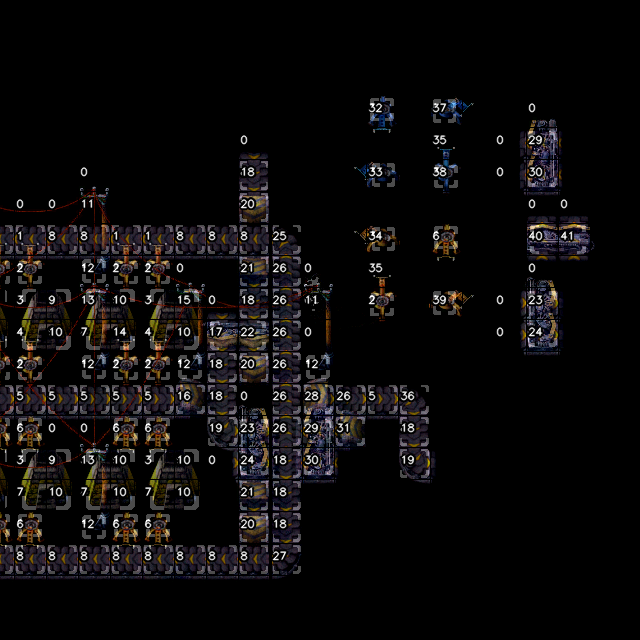

In [7]:


im = fg.copy()
for cc, (idx, idxs) in cls.items():

    for i in idxs:
        x, y = coords[i]
        putOutlinedText(im, f'{cc}', (x+2, y + 16), sz=0.35)
        # putOutlinedText(coords[i])
        pass
    pass

def unify_classes(cls, p, q):
    cls[p][1].update(cls[q][1])


marks = cv.imread('../tmp/test_get_tooltip1_marks.bmp')

mm = np.clip((im.astype(np.float32) + marks.astype(np.float32)*0.3), 0, 255).astype(np.uint8)

dis(im, mm)

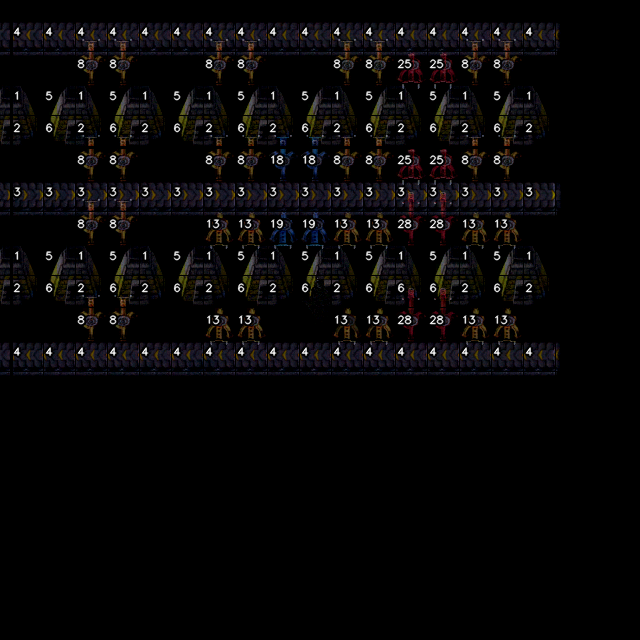

In [22]:
import copy

clsc = copy.deepcopy(cls)

im = fg.copy()

def unify_classes(cls, p, q):
    cls[p][1].update(cls[q][1])
    del cls[q]


def same_classes(cls, subcls):
    for c in subcls:
        

for cc, (idx, idxs) in clsc.items():

    for i in idxs:
        x, y = coords[i]
        putOutlinedText(im, f'{cc}', (x+2, y + 16), sz=0.35)
        # putOutlinedText(coords[i])
        pass
    pass
import os, glob
def dump_classes(dd, cls):
    if not os.path.exists(f'../tmp/classes'):
        os.mkdir('../tmp/classes')
    for cc, (idx, idxs) in cls.items():
        if not os.path.exists(f'../tmp/classes/{cc}'):
            os.mkdir(f'../tmp/classes/{cc}')
        assert idx in idxs
        lst = glob.glob(f'../tmp/classes/{cc}/*.bmp')
        ofs = len(lst)
        for i, idx in enumerate(idxs):
            img = cv.cvtColor(dd[idx][0], cv.COLOR_RGB2BGR)
            cv.imwrite(f'../tmp/classes/{cc}/{i + ofs}.bmp', img)


dump_classes(dd, clsc)

dis(im)

In [44]:
map_str = '''
rrrd____
___d____
___d____
___rrrrr
___u____
___u____
___u____
rrru____
'''

map_str = '''
_d_
_u_
_u_
'''

directions = {
    'r': (0, 1),
    'l': (0, -1),
    'u': (-1, 0),
    'd': (1, 0)
}

reverse_directions = {
    'r': (0, -1),
    'l': (0, 1),
    'u': (1, 0),
    'd': (-1, 0)
}

# Remove leading and trailing whitespace, split by lines, and replace '_' with ' ' for empty spaces
def strmap_to_grid(map_str: str):
    lines = map_str.strip().split('\n')
    grid = [list(line.replace('_', ' ')) for line in lines]
    return grid

# Function to check if a cell has a belt
def is_belt(grid, row, col):
    return 0 <= row < len(grid) and 0 <= col < len(grid[row]) and grid[row][col] in directions

# Function to find the sink for a given source
def find_sink(grid, row, col):
    while is_belt(grid, row, col):
        direction = grid[row][col]
        dr, dc = directions[direction]
        new_row, new_col = row + dr, col + dc
        if not is_belt(grid, new_row, new_col):
            break
        row, col = new_row, new_col
    return row, col


def get_source_sink(grid):
    sources = []

    # Traverse the grid to find all sources
    for row in range(len(grid)):
        for col in range(len(grid[row])):
            if grid[row][col] in directions:
                has_incoming = False

                # Check for incoming belts
                for dir_key, (dr, dc) in reverse_directions.items():
                    incoming_row, incoming_col = row + dr, col + dc
                    if is_belt(grid, incoming_row, incoming_col) and grid[incoming_row][incoming_col] in directions:
                        direction_into_current = grid[incoming_row][incoming_col]
                        if directions[direction_into_current] == (-dr, -dc):
                            has_incoming = True
                            break

                if not has_incoming:
                    sources.append((row, col))

    source_sink_pairs = []

    # Find all (source, sink) pairs
    for source in sources:
        sink = find_sink(grid, *source)
        source_sink_pairs.append((source, sink))
    
    return source_sink_pairs

def follow(grid, p):
    p = np.array(p)
    g = np.array(grid)
    d = g[*p]
    # print(d)
    dd = directions[d]
    p_ = np.array(p) + dd
    while g[*p_] == d:
        p_ += dd
    # print(p_, g[*p_])
    if g[*p_] != ' ':
        return [p] + follow(grid, p_)
    else:
        return [p, p_]


def strmap_to_paths(map_str):
    gr = strmap_to_grid(map_str)
    paths = []
    for pair in get_source_sink(gr):
        ga = np.array(gr)
        lst = follow(ga, pair[0])
        paths.append(lst)
    return paths

print(strmap_to_paths(map_str))

'''
1. get map repr
2. get list of (source, sink)
3. for each source, sink create a path with follow
4. traverse the path

'''

print()

KeyboardInterrupt: 

In [63]:
import numpy as np
from typing import Callable, Tuple

class NumpyExtension:
    def __init__(self, array: np.ndarray):
        self.array = array
        
    def __or__(self, operation: Callable[['NumpyExtension'], 'NumpyExtension']) -> 'NumpyExtension':
        return operation(self)

    def __array__(self):
        return self.array

    def __repr__(self):
        return repr(self.array)

def resize(fx: float, fy: float) -> Callable[[NumpyExtension], NumpyExtension]:
    def operation(ext: NumpyExtension) -> NumpyExtension:
        arr = ext.array
        resized = cv.resize(arr, None, fx=fx, fy=fy)
        return NumpyExtension(resized)
    return operation

def threshold(thr_val: int, high_value: int) -> Callable[[NumpyExtension], NumpyExtension]:
    def operation(ext: NumpyExtension) -> NumpyExtension:
        arr = ext.array
        _, msk = cv.threshold(arr, thr_val, high_value, cv.THRESH_BINARY)
        return NumpyExtension(msk)
    return operation

image = cv.imread('../tmp/qweqwe.bmp')
ext_image = NumpyExtension(image)

ext_image |= resize(2, 2.0)
ext_image |= threshold(50, 255)

dis(ext_image.array, image)

In [19]:
import cv2 as cv
import numpy as np

im = cv.imread('../tmp/test_get_tooltip1_fg.bmp')
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

gr = cv.cvtColor(im, cv.COLOR_RGB2GRAY)

comp = cv.imread('../tmp/test_get_tooltip1_comp.bmp')
comp = cv.cvtColor(comp, cv.COLOR_BGR2RGB)
get_grid(comp, grid_color=(32,32,32))
print(gr.ndim)
# dis(comp)

2


In [105]:
def build_graph_from_map(bmap: str):

    bmap = bmap.strip('\n \t').split('\n')
    moves = {
        'u': (-1, 0),
        'd': (1, 0),
        'r': (0, 1),
        'l': (0, -1),
        '_': (0, 0)
    }

    allowed_moves = {
        'u': ('l', 'r', 'u'),
        'd': ('l', 'r', 'd'),
        'r': ('r', 'd', 'u'),
        'l': ('l', 'd', 'u'),
    }

    def is_valid(x, y):
        return 0 <= x < len(bmap) and 0 <= y < len(bmap[0]) and bmap[x][y] != '_'

    graph = {}
    for i in range(len(bmap)):
        for j in range(len(bmap[0])):
            if bmap[i][j] == '_':
                continue
            graph[(i, j)] = []
            i_, j_ = moves[bmap[i][j]]
            i1 = i + i_
            j1 = j + j_
            if not is_valid(i1, j1):
                continue
            if bmap[i1][j1] in allowed_moves[bmap[i][j]]:
                graph[(i,j)].append((i1, j1))


    return graph

def find_all_paths(graph):
    def dfs(node, path):
        # Append current node to the path
        path.append(node)
        
        # Check if the node has no outgoing edges (i.e., end of path)
        if node not in graph or not graph[node]:
            all_paths.append(path.copy())
        else:
            for next_node in graph[node]:
                dfs(next_node, path)
        
        # Remove the current node to backtrack
        path.pop()

    all_paths = []
    
    # Call DFS from each node that is not in the middle of a path
    # A node is a start node if it does not appear as a destination in the graph
    start_nodes = set(graph.keys()) - {node for edges in graph.values() for node in edges}
    for start_node in start_nodes:
        dfs(start_node, [])

    # Filter out subpaths
    non_subpaths = []
    
    for path in all_paths:
        is_subpath = False
        for other_path in all_paths:
            if path != other_path and path == other_path[:len(path)]:
                is_subpath = True
                break
        if not is_subpath:
            non_subpaths.append(path)
    
    return non_subpaths

def collapse_paths(smap, paths):
    smap = smap.strip('\n \t').split('\n')
    out = []
    for path in paths:
        out1 = [path[0]]
        pp = path[0]
        cnt = 1
        for p in path[1:]:
            a = smap[p[0]][p[1]]
            b = smap[pp[0]][pp[1]]
            if a != b:
                cnt = 1
                pp = p
                out1.append(p)
            else:
                cnt += 1
        if cnt > 1:
            out1.append(path[-1])
        out.append(out1)
    return out

# Example usage
smap = '''
___u___
___u___
__ru___
__uu___
__uu___
'''

graph = build_graph_from_map(smap)
paths = find_all_paths(graph)
rr = collapse_paths(smap, paths)
print(rr)


[[(4, 2), (2, 2), (2, 3), (0, 3)], [(4, 3), (0, 3)]]
